# Data Understanding

In [2]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import gc # garbage collector to save memory

# utility functions, see utils.py
import utils

In [3]:
# Specify paths for data and figures 
DATA_PATH = "C:/dev/studienarbeit/ashrae-energy-prediction-data/csv"
PICKLE_PATH = "C:/dev/studienarbeit/ashrae-energy-prediction-data/pkl"
FIGURE_PATH = "C:/dev/studienarbeit/ashrae-energy-prediction-data/figures"

In [4]:
# Visualization parameters 
sns.set_theme(style="whitegrid", palette="Set2")

matplotlib.rcParams["backend"] = "pdf"
matplotlib.rcParams["figure.figsize"] = (10, 3)
matplotlib.rcParams["figure.dpi"] = 100
matplotlib.rcParams["figure.constrained_layout.use"] = "True"
matplotlib.rcParams["savefig.bbox"] = "tight"
matplotlib.rcParams["savefig.pad_inches"] = 0
matplotlib.rcParams["savefig.directory"] = FIGURE_PATH
matplotlib.rcParams["savefig.format"] = "pdf"

## General description of the datasets
### Files
**train.csv**
-   `building_id` - Foreign key for the building metadata.
-   `meter` - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
-   `timestamp` - When the measurement was taken
-   `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed [here](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261), the site 0 electric meter readings are in kBTU.

**building_meta.csv**
-   `site_id` - Foreign key for the weather files.
-   `building_id` - Foreign key for `training.csv`
-   `primary_use` - Indicator of the primary category of activities for the building based on [EnergyStar property type definitions](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type)
-   `square_feet` - Gross floor area of the building
-   `year_built` - Year building was opened
-   `floor_count` - Number of floors of the building

**weather_[train/test].csv**
Weather data from a meteorological station as close as possible to the site.
-   `site_id`
-   `air_temperature` - Degrees Celsius
-   `cloud_coverage` - Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta)
-   `dew_temperature` - Degrees Celsius
-   `precip_depth_1_hr` - Millimeters
-   `sea_level_pressure` - Millibar/hectopascals
-   `wind_direction` - Compass direction (0-360)
-   `wind_speed` - Meters per second

**test.csv**
The submission files use row numbers for ID codes in order to save space on the file uploads. `test.csv` has no feature data; it exists so you can get your predictions into the correct order.
-   `row_id` - Row id for your submission file
-   `building_id` - Building id code
-   `meter` - The meter id code
-   `timestamp` - Timestamps for the test data period

**sample_submission.csv**
A valid sample submission.
-   All floats in the solution file were truncated to four decimal places; we recommend you do the same to save space on your file upload.
-   There are gaps in some of the meter readings for both the train and test sets. Gaps in the test set are not revealed or scored.

## Explore files

In [7]:
train = pd.read_csv(f"{DATA_PATH}/train.csv")
test = pd.read_csv(f"{DATA_PATH}/test.csv")
building_metadata = pd.read_csv(f"{DATA_PATH}/building_metadata.csv")
weather_train = pd.read_csv(f"{DATA_PATH}/weather_train.csv")
weather_test = pd.read_csv(f"{DATA_PATH}/weather_test.csv")

In [18]:
def mem_usage_shape(df, name):
    print(name)
    print(df.info())
    print("-----")
    
mem_usage_shape(train, "train")
mem_usage_shape(test, "test")
mem_usage_shape(building_metadata, "building_metadata")
mem_usage_shape(weather_train, "weather_train")
mem_usage_shape(weather_test, "weather_test")

train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   building_id    int64  
 1   meter          int64  
 2   timestamp      object 
 3   meter_reading  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 616.9+ MB
None
-----
test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41697600 entries, 0 to 41697599
Data columns (total 4 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   row_id       int64 
 1   building_id  int64 
 2   meter        int64 
 3   timestamp    object
dtypes: int64(3), object(1)
memory usage: 1.2+ GB
None
-----
building_metadata
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   site_id      1449 non-null   int64  
 1   building_id  1449 non-null   int64  
 2   primary_us

In [26]:
# delete variables as we load the data as a merged dataframe in the cells below
del train, test, building_metadata, weather_train, weather_test

## Construct dataframes
The method `load_data` will load and merge it with the respective weather and building data either the training or test set and reduce its memory size by changing the datatypes for each column (see utils.py) and return a dataframe. If `from_pickle` is True, we load the dataframe from a pickle file, which is faster.

In [27]:
train = utils.load_data(dataset='train', data_path=DATA_PATH, pickle_path=PICKLE_PATH, from_pickle=True, merge_weather_building=True, reduce_mem=True)
test = utils.load_data(dataset='test', data_path=DATA_PATH, pickle_path=PICKLE_PATH, from_pickle=True, merge_weather_building=True, reduce_mem=True)

gc.collect()
print(f"Loading of dataframes complete.\nTrain shape: {train.shape}\nTest shape: {test.shape}")
print(f"Memory usage: {round(train.memory_usage().sum() / 1024**2, 2)} MB (train), {round(test.memory_usage().sum() / 1024**2, 2)} MB (test)")

Loading of dataframes complete.
Train shape: (20216100, 16)
Test shape: (41697600, 15)
Memory usage: 1041.1 MB (train), 1988.3 MB (test)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               int8          
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   site_id             int8          
 5   primary_use         object        
 6   square_feet         int32         
 7   year_built          float16       
 8   floor_count         float16       
 9   air_temperature     float16       
 10  cloud_coverage      float16       
 11  dew_temperature     float16       
 12  precip_depth_1_hr   float16       
 13  sea_level_pressure  float16       
 14  wind_direction      float16       
 15  wind_speed          float16       
dtypes: datetime64[ns](1), float16(9), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 1.0+ GB


## Exploratory Data Analysis

### Missing Values

Our dataset has missing values across some columns. Columns building_id, meter, timestamp, meter_reading, site_id, primary_use, and square_feet all have no missing values. The features with the highest rate of missing values are floor_count, year_built, and cloud_coverage which we have to look out for in data preparation.

C:\Users\Raphael\AppData\Local\Temp/ipykernel_14984/1509240659.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(labels=missing_values.index, rotation=90);


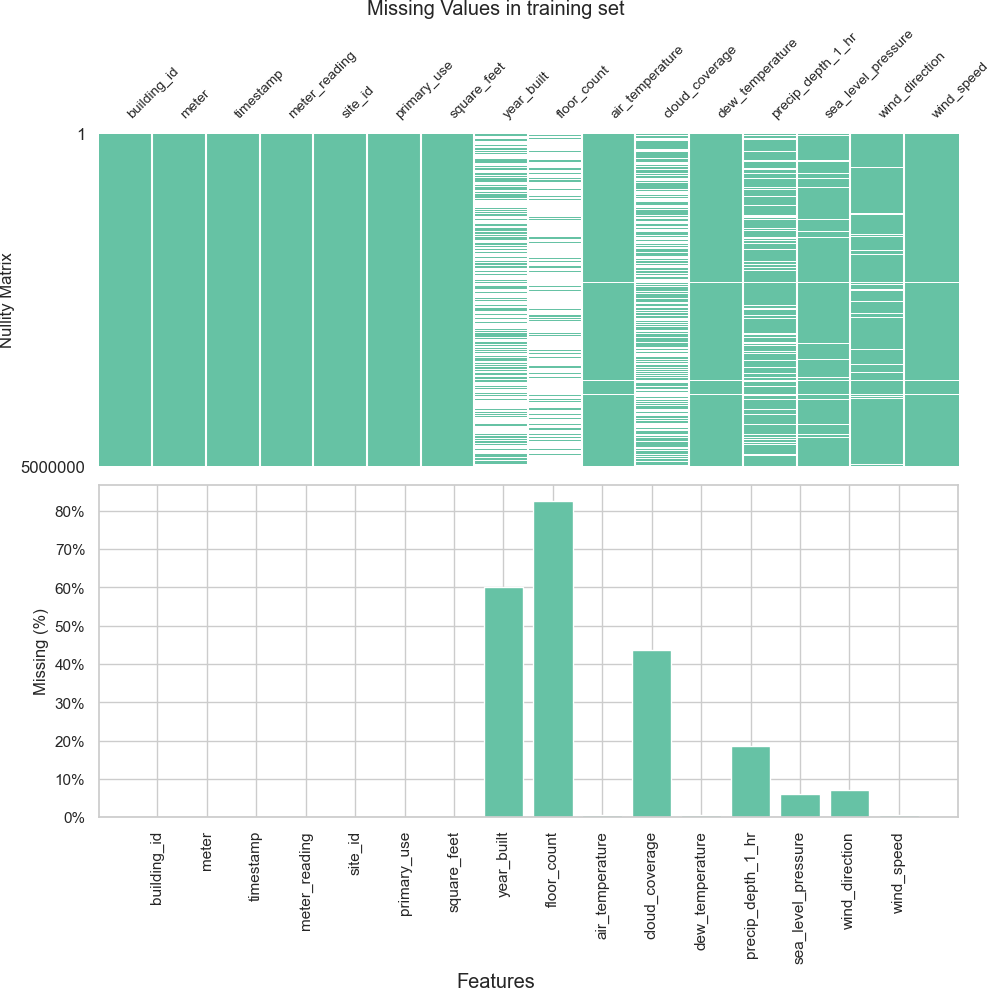

In [166]:
import missingno as msno # see https://github.com/ResidentMario/missingno

fig, ax = plt.subplots(2,1, figsize=(10,10))

# Top plot
msno.matrix(train.sample(5000000), color=(0.4,0.761,0.647), fontsize=10, ax=ax[0], sparkline=False) 
ax[0].set_ylabel("Nullity Matrix")

# Bottom plot
missing_values = train.isnull().sum()/len(train) 
ax[1].bar(missing_values.index, missing_values)
ax[1].set_ylabel("Missing (%)")
ax[1].set_xticklabels(labels=missing_values.index, rotation=90);
ax[1].yaxis.set_major_formatter(lambda x, pos: f"{int(x*100)}%")

# Common Labels
fig.suptitle("Missing Values in training set")
fig.supxlabel("Features")

plt.savefig(f"{FIGURE_PATH}/missing_values.png", format="png") # save as png because pdf was corrupted

### Target Distribution
We see that the target variable meter_reading is heavily skewed towards 0 kWh. We also find that we have to be wary of outliers.

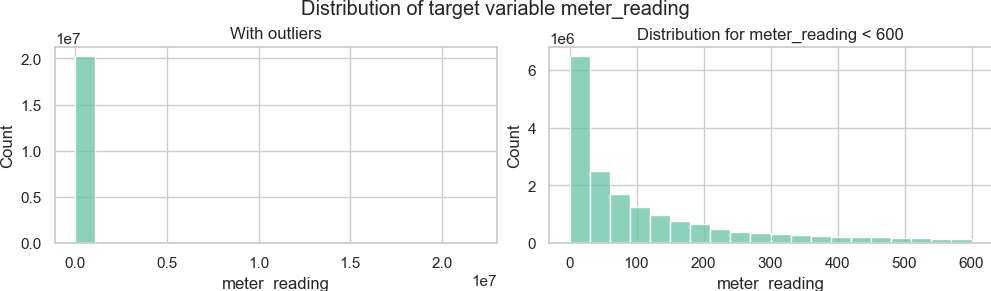

In [158]:
fig, ax = plt.subplots(1,2, figsize=(10,3))
sns.histplot(
    data=train, 
    x="meter_reading", 
    element="bars",
    bins=20,
    ax=ax[0]
)
ax[0].set_title("With outliers")
sns.histplot(
    data=train[(train["meter_reading"] < 600)], 
    x="meter_reading", 
    element="bars",
    bins=20,
    ax=ax[1]
)
ax[1].set_title("Distribution for meter_reading < 600")
fig.suptitle("Distribution of target variable meter_reading")
plt.savefig(f"{FIGURE_PATH}/target_variable")

During our analysis we found that meter 2 of building 1099 is a significant outlier in the dataset. During the course of the competition it also became apparent that some readings from site 0 (encompassing buildings 1-104) have energy readings using the wrong units. This has been noted by the [community on Kaggle](https://www.kaggle.com/c/ashrae-energy-prediction/discussion/118753) and by [Miller, 2020](https://www.nature.com/articles/s41597-020-00712-x). We will remove the outliers from our dataset when training our models.

In [29]:
train_rm_outliers = train.query("not (((building_id == 1099) & (meter == 2)) or (building_id <= 104 & meter == 0 & timestamp <= '2016-05-20'))")

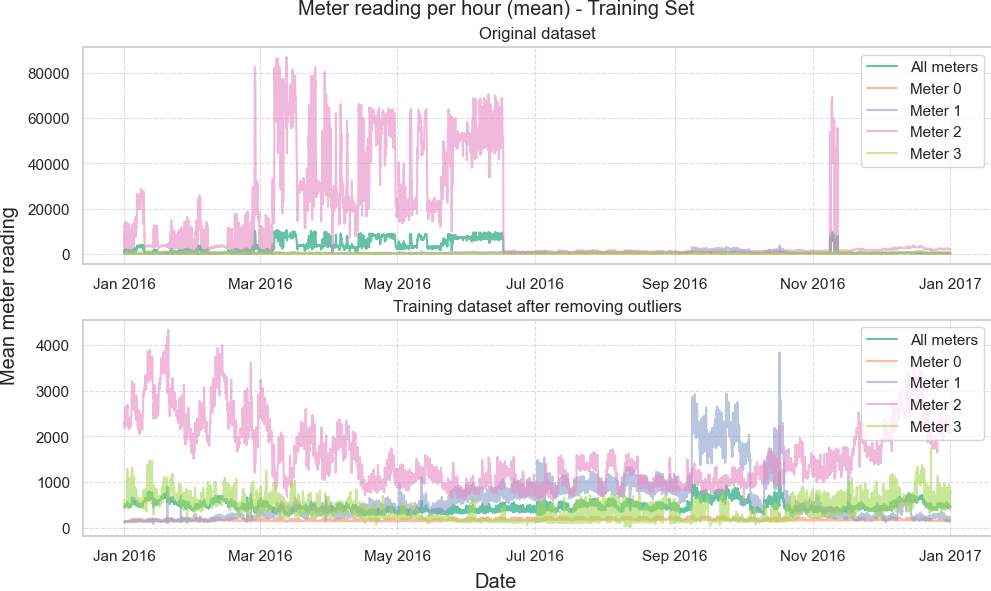

In [159]:
mean_meter_per_hour = train[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

# Mean across all meters
ax[0].plot(mean_meter_per_hour, label="All meters")
for meter in [0,1,2,3]:
    # Mean per meter
    data = train[train["meter"] == meter][["timestamp", "meter_reading"]].set_index('timestamp').resample('H').mean()
    ax[0].plot(data, alpha=0.6, label=f"Meter {meter}")

# Axis settings
ax[0].set_title("Original dataset")
ax[0].grid(which='major', color='#DDDDDD', linestyle='--', linewidth=0.8)
ax[0].xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=2)) 
ax[0].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %Y')) # Timestamp is displayed as "Jan 2016"
ax[0].legend()

# Bottom plot (outliers) removed
mean_meter_per_hour_rm_outliers = train_rm_outliers[['timestamp', 'meter_reading']].set_index('timestamp').resample('H').mean()

# Mean across all meters
ax[1].plot(mean_meter_per_hour_rm_outliers, label="All meters")
for meter in [0,1,2,3]:
    # Mean per meter
    data = train_rm_outliers[train_rm_outliers["meter"] == meter][["timestamp", "meter_reading"]].set_index('timestamp').resample('H').mean()
    ax[1].plot(data, alpha=0.6, label=f"Meter {meter}")

ax[1].set_title("Training dataset after removing outliers")
ax[1].grid(which='major', color='#DDDDDD', linestyle='--', linewidth=0.8)
ax[1].xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=2)) 
ax[1].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b %Y'))
ax[1].legend(loc="upper right")


fig.supxlabel("Date")
fig.supylabel("Mean meter reading")
fig.suptitle("Meter reading per hour (mean) - Training Set")

plt.savefig(f"{FIGURE_PATH}/mean_reading_per_hour")

### Mean meter reading by `primary_use` per day
We look at how the energy usage is different for different times of day. We see that Education, Office, Public services, Retail, Other, and Technology/Science all peak in the middle of the day and have their lowest energy usage in the evening and at night. Lodging/Residential is lowest in the night but is then consistently high during the day with the highest peak in the evening. Manufacturing/industrial peaks in the morning and then falls off after noon. Parking is interesting because it is inverse to all other building types with the highest usage in the evening and at night. This is consistent with domain knowledge, because parking buildings are usually not heated or cooled and mostly only use energy for lighting, which is needed less during daytime. Services and Warehouse/storage both have two peaks during the daytime whereas the other building types do not.

In [31]:
train_rm_outliers["hour"] = train["timestamp"].dt.hour.astype(np.int8)
train_group_hour_pu = train_rm_outliers.groupby(["hour", "primary_use"], as_index=False).mean()

C:\Users\Raphael\AppData\Local\Temp/ipykernel_8780/2870429915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_rm_outliers["hour"] = train["timestamp"].dt.hour.astype(np.int8)


C:\Users\Raphael\AppData\Local\Temp/ipykernel_8780/944134279.py:13: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=0.08, top=0.9, bottom=0.1, hspace=0.35, wspace=0.3)


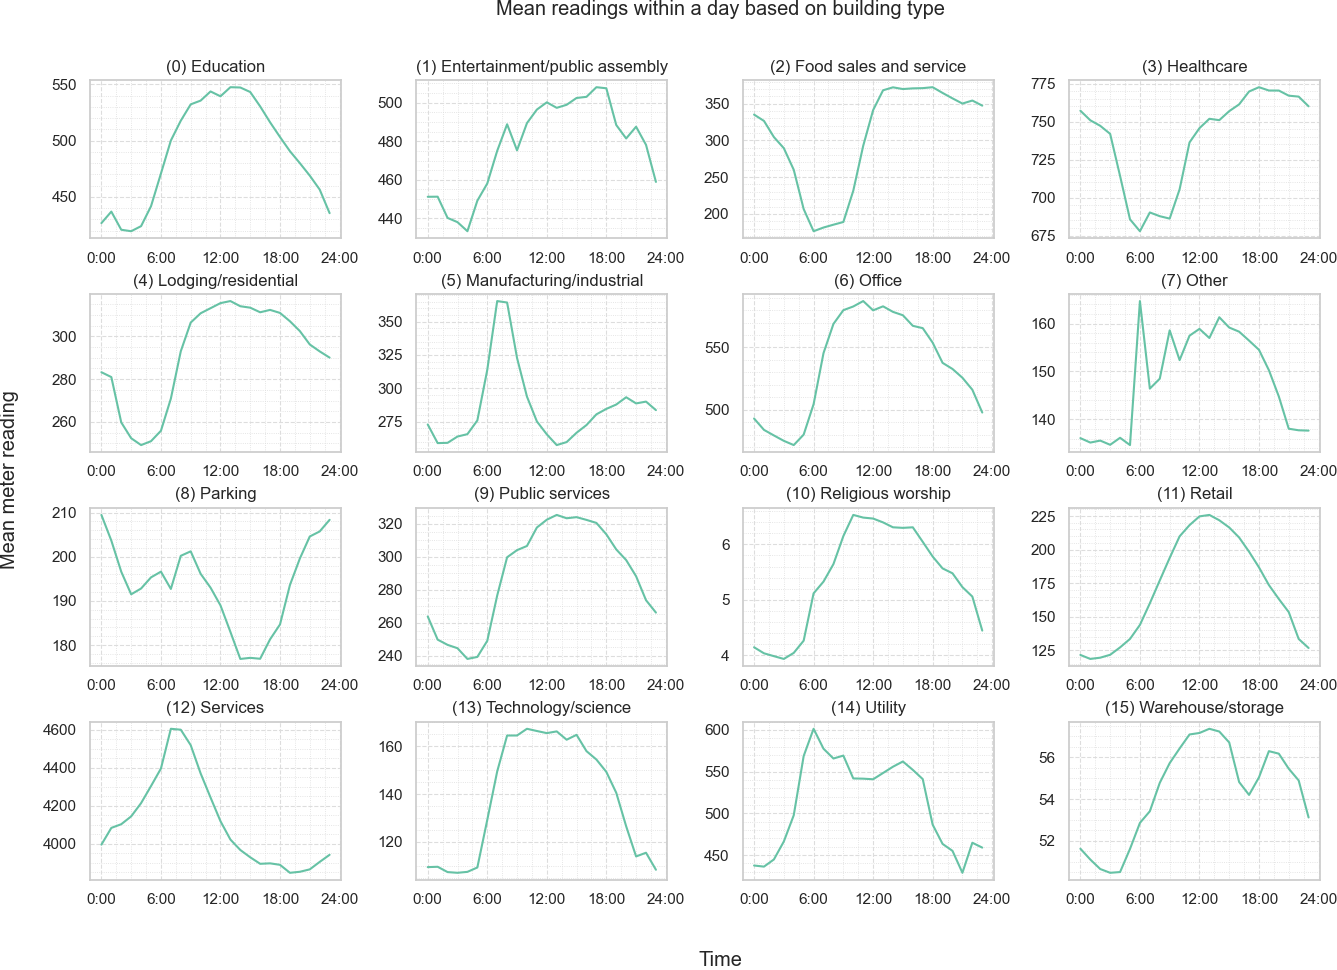

In [32]:
fig, ax = plt.subplots(4, 4, figsize=(15, 10))
primary_uses = train_group_hour_pu["primary_use"].unique()
for i in range(len(primary_uses)):
    data = train_group_hour_pu[train_group_hour_pu["primary_use"] == primary_uses[i]]
    ax_cur = ax[i//4][i%4]
    ax_cur.plot(data["hour"], data["meter_reading"])
    ax_cur.set_title(f"({i}) {primary_uses[i]}");
    ax_cur.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(6))
    ax_cur.xaxis.set_major_formatter(lambda x, pos: str(int(x)) + ":00")
    ax_cur.minorticks_on()
    ax_cur.grid(which='major', color='#DDDDDD', linestyle='--', linewidth=0.8)
    ax_cur.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.6)
plt.subplots_adjust(left=0.08, top=0.9, bottom=0.1, hspace=0.35, wspace=0.3)
fig.supxlabel("Time")
fig.supylabel("Mean meter reading")
fig.suptitle("Mean readings within a day based on building type")

plt.savefig(f"{FIGURE_PATH}/building_type_daily")

### Mean meter reading by `site_id` over the whole year
We look at how the energy usage changes throughout the year for each site. We see that for Sites 4, 5 and 12 the energy usage does not change much throughout the year. In site 16 there probably is an outlier in September. Sites 3, 7, 11 and 14 have a similar course with a peak in summer and the lowest energy usage in spring and autumn. 

C:\Users\Raphael\AppData\Local\Temp/ipykernel_8780/2167771600.py:16: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=0.08, top=0.9, bottom=0.1, hspace=0.35, wspace=0.3)


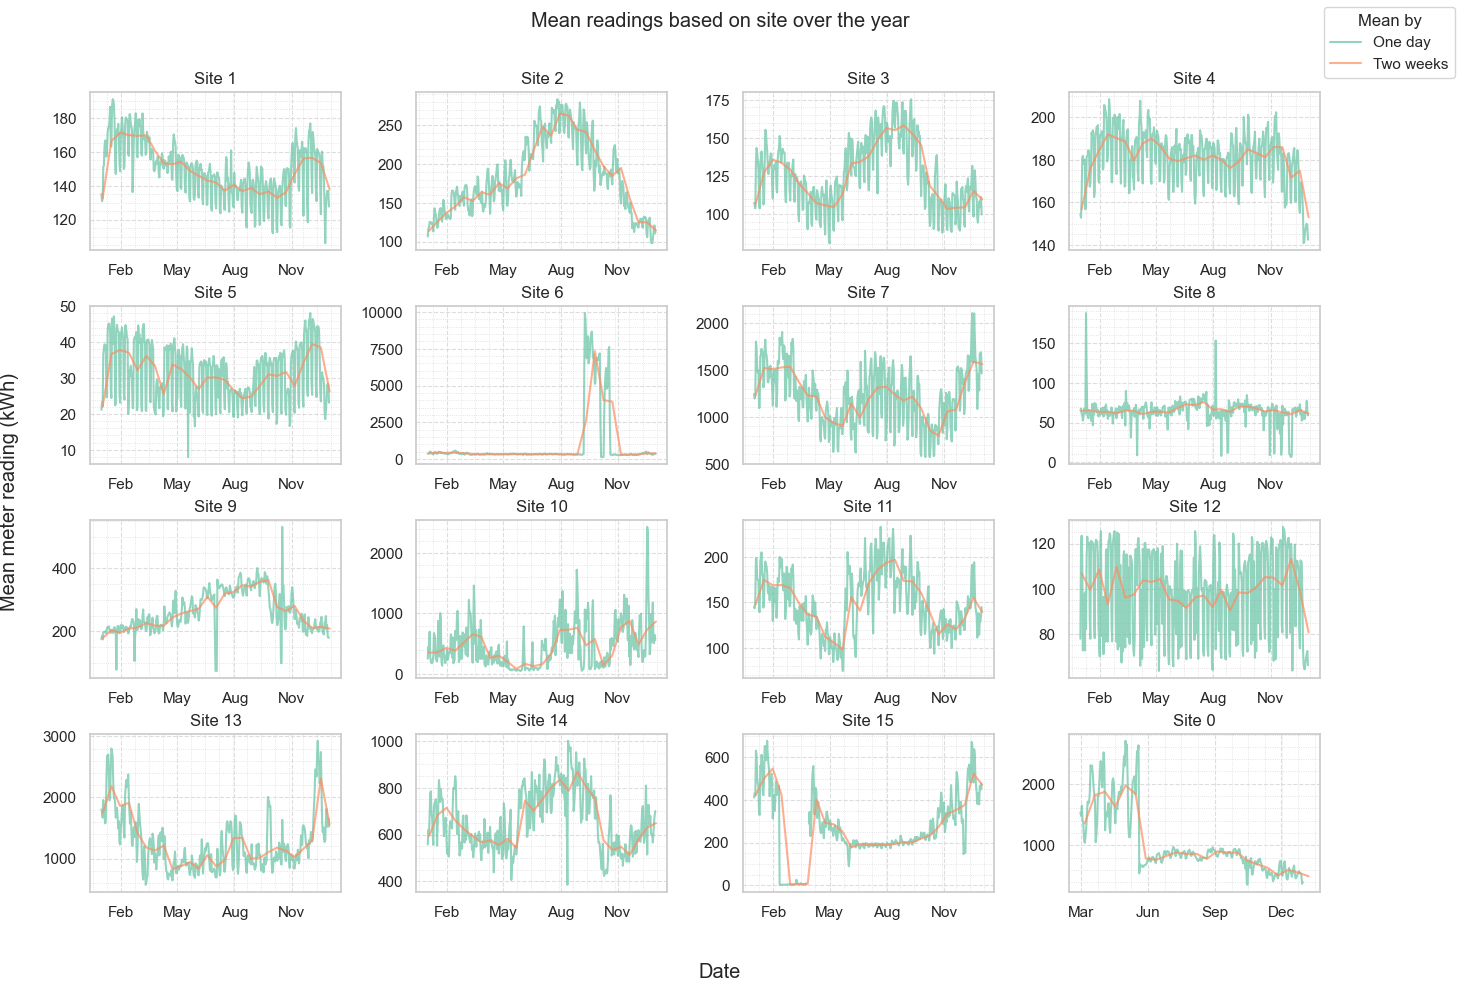

In [33]:
fig, ax = plt.subplots(4, 4, figsize=(15, 10))
sites = train_rm_outliers["site_id"].unique()
for i in range(len(sites)):
    data = train_rm_outliers[train_rm_outliers["site_id"] == sites[i]][["timestamp", "meter_reading"]].set_index('timestamp').resample('D').mean()
    data_m = train_rm_outliers[train_rm_outliers["site_id"] == sites[i]][["timestamp", "meter_reading"]].set_index('timestamp').resample('2W').mean()
    ax_cur = ax[i//4][i%4]
    ax_cur.plot(data, alpha=0.7, label="Day")
    ax_cur.plot(data_m, alpha=0.7, label="Two weeks")
    ax_cur.set_title(f"Site {sites[i]}");
    ax_cur.xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=3))
    ax_cur.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    ax_cur.minorticks_on()
    ax_cur.grid(which='major', color='#DDDDDD', linestyle='--', linewidth=0.8)
    ax_cur.grid(which='minor', color='#DDDDDD', linestyle=':', linewidth=0.6)
    #ax_cur.tick_params(axis='x', rotation=90)
plt.subplots_adjust(left=0.08, top=0.9, bottom=0.1, hspace=0.35, wspace=0.3)
fig.supxlabel("Date")
fig.supylabel("Mean meter reading (kWh)")
fig.suptitle("Mean readings based on site over the year")
fig.legend(["One day", "Two weeks"], title="Mean by")

plt.savefig(f"{FIGURE_PATH}/mean_reading_site_year")

### Correlation Matrix
Here we see how features are correlated. Interestingly `floor_count` and `square_feet` are strongly positively correlated, as are `air_temperature` and `dew_temperature`. When looking at the target variable `meter_reading` we find that `year_built` and `floor_count` both have a positive correlation, i.e. on average newer buildings and buildings with more floors have a higher energy usage.

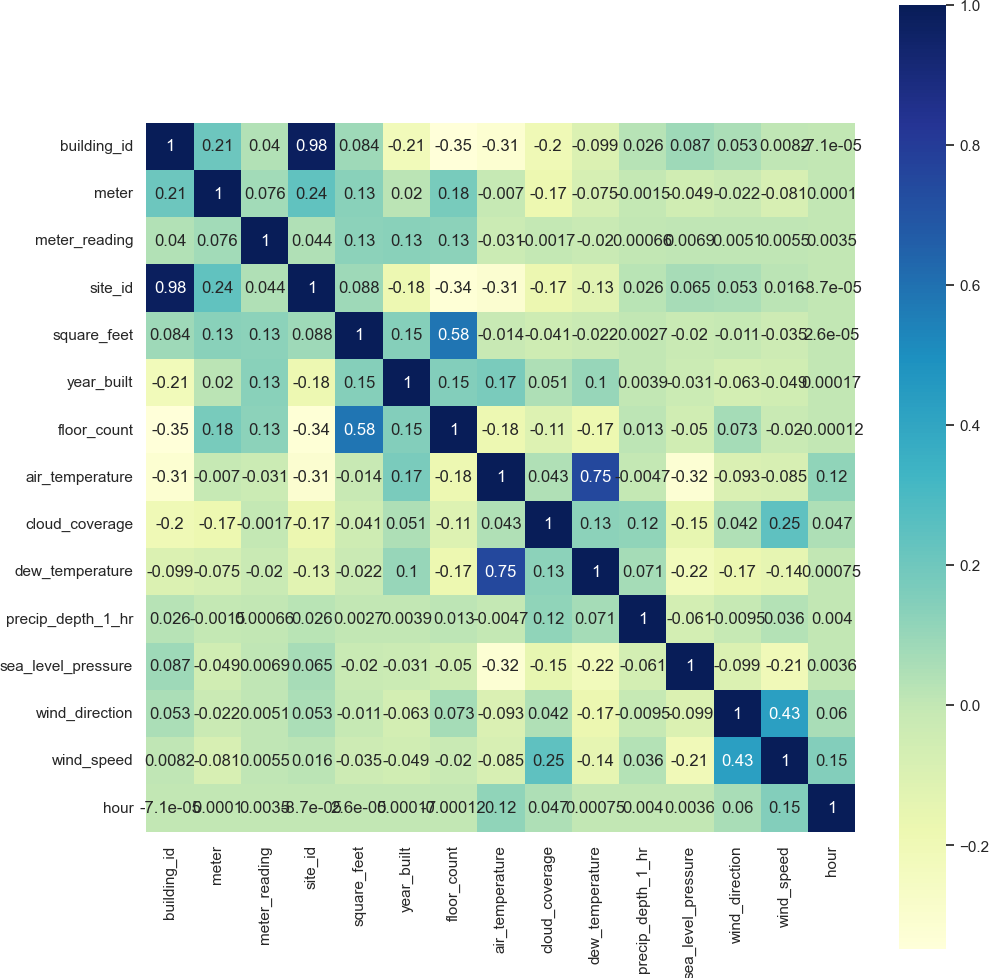

In [34]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
sns.heatmap(train_rm_outliers.corr(), annot=True, square=True, cmap="YlGnBu", ax=ax)
plt.savefig(f"{FIGURE_PATH}/correlation_matrix")

With what we have learned through our exploratory data analysis we will now move into Data Preparation and Modeling in Notebook `02 Modeling.ipynb`.